### To run this model yourself: go to Run -> Run All Cells in the top left menu bar.

In [ ]:
from epx import FREDJob, FREDModelConfig, ModelConfigSweep, SynthPop
from itertools import product

import data_tools as dt

# Simulating a Respiratory Disease Outbreak

### In this notebook, we will model the spread of an influenza through Kewaunee County, WI.

Our influenza model uses an SEIR structure. If you'd like to learn more about disease transmission in FRED, check out Lesson 7 in the Quickstart Guide.

For now, here's a brief overview of the model:
- We begin with 10 agents randomly exposed to the disease. 
- Exposed agents become Infectious after an average of two days, and they can either be Symptomatic (66%) or Asymptomatic (33%). 
- Agents remain infectious for an average of 5 days, during which they can transmit the disease to other susceptible agents that they come into contact with. 
After the infectious period, they recover and are no longer susceptible to reinfection.

In [ ]:
flu_config = FREDModelConfig(
    synth_pop=SynthPop("US_2010.v5", ["Kewaunee_County_WI"]),
    start_date="2023-01-01",
    end_date="2023-07-01",
)
fred_ref_files = {}
fred_include_files = [
    "mode/main.fred",
    "model/simpleflu.fred"]

flu_job = FREDJob(
    config=[flu_config],
    tags=["cl_flu_job","epx-client-1.2.0"],
    fred_version="11.0.1",
    fred_files=fred_include_files,
    ref_files=fred_ref_files
)

flu_job.execute(300)

str(flu_job.status)

## Exploring the Model Output

In [ ]:
baseline_states = dt.get_states(flu_job)
baseline_exposures = dt.get_explocs(flu_job)
baseline_locations = dt.get_expmap_data(flu_job)

In [ ]:
dt.plot_epicurves(baseline_states)

Our influenza model tracks how many agents are newly exposed, infectious, or recovered each day. In the figure above, we can see that it takes about two weeks from the initial seeding of exposures at the beginning of the simulation for community spread to increase substantially, and that the disease has run its course after about 10 weeks.

Below we plot an animation of infections colored by the type of location at which the exposure occurred (Household, Workplace, etc)  for the duration of the simulation.

In [ ]:
dt.plot_animation_by_exposure_location(baseline_exposures)

Here we show the same data as in the above animation, but summarized into an interactive map with the size of the circles representing households, workplaces, and schools scaled proportionally to the number of agent-to-agent transmission events that took place in those locations throughout the simulation. This helps us visually locate places that experienced unusually high numbers of infections.

In [ ]:
dt.plot_static_exposure_locations(baseline_locations)

Our influenza model also records the demographic characterstics of the agents that were exposed to influenza, so we can segment our exposure data according to those demographic characteristics.

In [ ]:
dt.get_exposure_table_by_demog_group(baseline_exposures)

Here we show another animated map of the same simulation data, this time color-coded by the demographic attributes of the agents that were exposed.

In [ ]:
dt.plot_animation_by_demog_group(baseline_exposures)

The corresponding time series of infections for the above animation is shown below.

In [ ]:
dt.plot_time_series_by_demog_group(baseline_exposures)

In [ ]:
# deleting our job now that we are done with it
flu_job.delete(interactive=False)

FRED is a powerful tool not just for understanding disease spread in the aggregate but also for exploring the individual behaviors that are contributing factors. As part of our baseline model, agents recorded where they were exposed to the respiratory disease.

# Exploring Different Outbreak Scenarios

We can use our baseline flu model as a jumping off point to explore different outbreak scenarios. That is, we can make different assumptions about the state of the world, people's behavior, etc., and see the effects of those assumptions on our outcomes of interest.

In this case, let's look at three key variables that we suspect will play an important role in determining the size of an outbreak:
1. The transmissibility of the strain of influenza causing the outbreak.
2. The tendency for sick people to isolate themselves (stay home from work or school) while experiencing symptoms.
3. The population's overall sentiment towards getting vaccinated against influenza.

Considering two possibilities for each variable, we have eight total scenarios in which our influenza outbreak might play out very differently:
| Transmissibility | Isolation | Vaccine Sentiment |
|------------------|-----------|-------------------|
| Low              | None      | Negative          |
| Low              | None      | Positive          |
| Low              | Some      | Negative          |
| Low              | Some      | Positive          |
| High             | None      | Negative          |
| High             | None      | Positive          |
| High             | Some      | Negative          |
| High             | Some      | Positive          |

Let's take a look under the hood and look at the components of the model that support these scenarios.

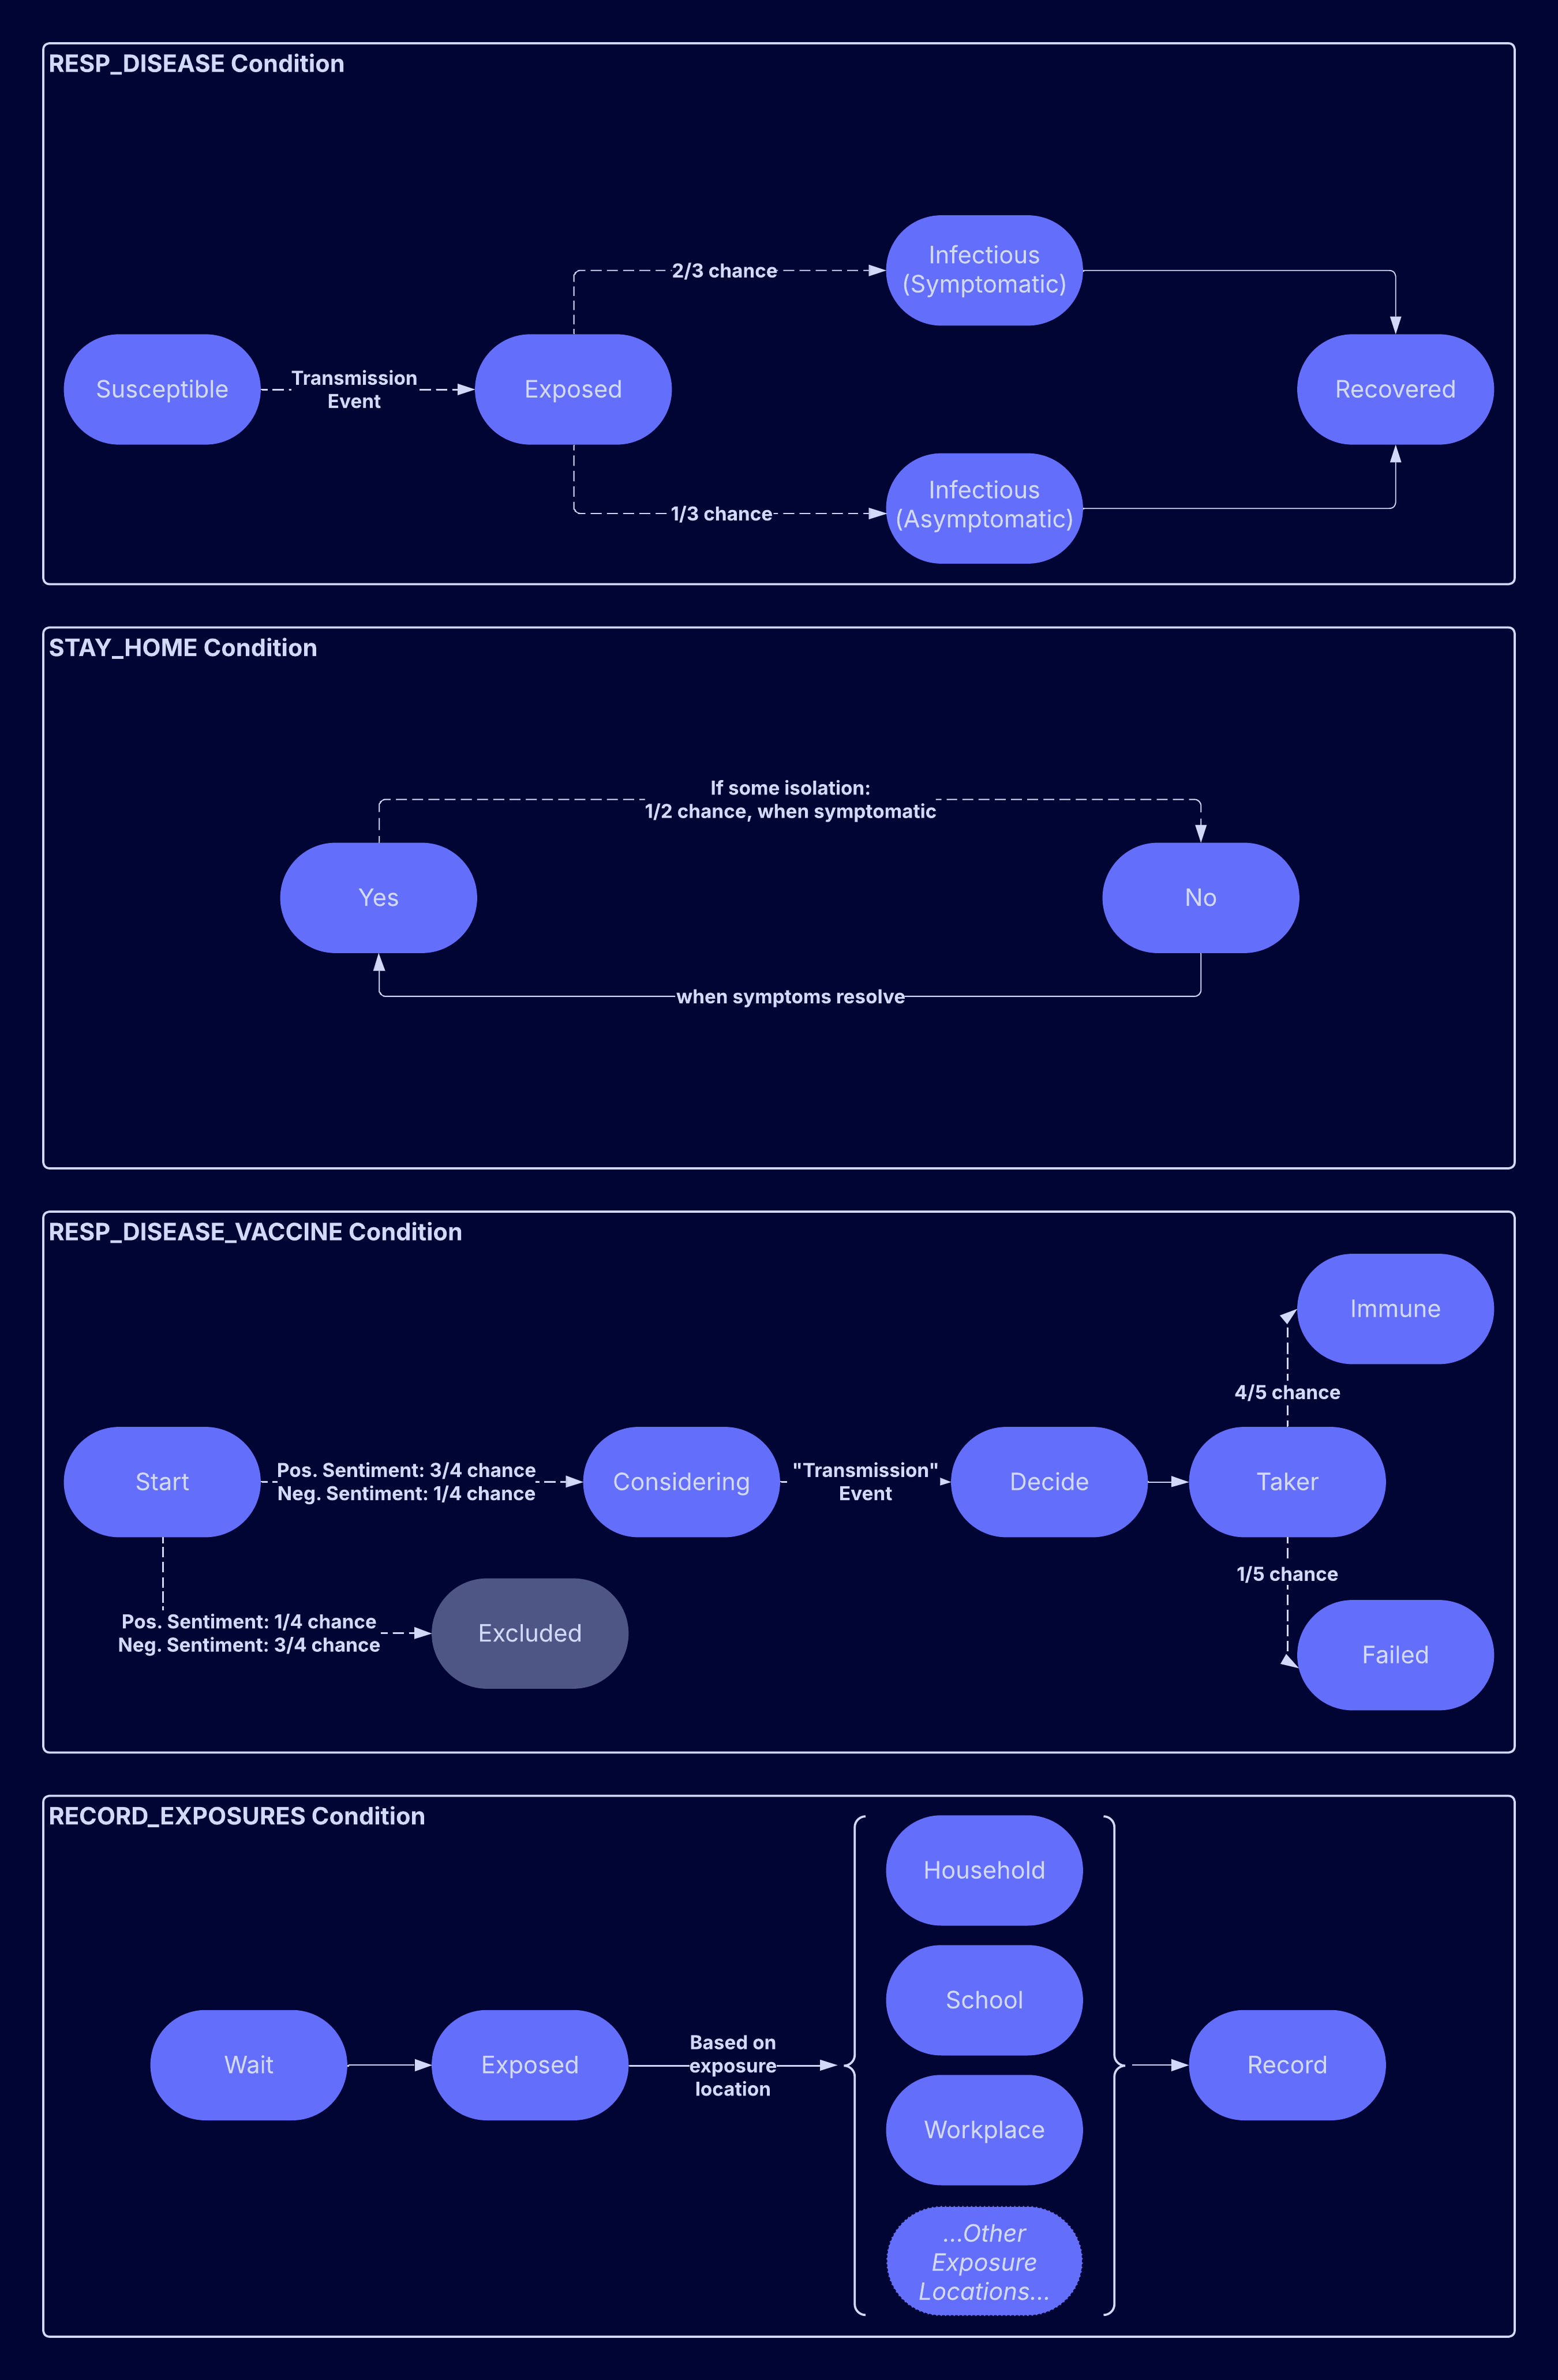

Now that we understand the model a bit better, we can simulate each of these scenarios and compare the results.

In [ ]:
# varying key parameters to explore different scenarios
sweep_params = {
    "transmissibility_reduction": [0.0, 0.25],
    "stay_home_prob": [0.0, 0.50],
    "willing_to_consider_vaccine": [0.25, 0.75]
}

flu_config_sweep = ModelConfigSweep(
    synth_pop=[SynthPop("US_2010.v5", ["Kewaunee_County_WI"])],
    start_date=["2023-01-01"],
    end_date=["2023-07-01"],
    model_params=[dict(zip(sweep_params, values)) for values in product(*sweep_params.values())],
    seed=dt.SWEEP_SEEDS
)

fred_ref_files = {}
fred_include_files = [
    "mode/main.fred",
    "model/simpleflu.fred"]

flu_sweep = FREDJob(
    config=[flu_config_sweep],
    tags=["cl_flu_sweep","epx-client-1.2.0"],
    fred_version="11.0.1",
    fred_files=fred_include_files,
    ref_files=fred_ref_files)

flu_sweep.execute(300)

str(flu_sweep.status)

In [ ]:
high_trans_runs = {
    0: "No Isolation,<br>Negative Vaccine Sentiment",
    1: "No Isolation,<br>Positive Vaccine Sentiment",
    2: "Some Isolation,<br>Negative Vaccine Sentiment",
    3: "Some Isolation,<br>Positive Vaccine Sentiment"
}
low_trans_runs = {
    4: "No Isolation,<br>Negative Vaccine Sentiment",
    5: "No Isolation,<br>Positive Vaccine Sentiment",
    6: "Some Isolation,<br>Negative Vaccine Sentiment",
    7: "Some Isolation,<br>Positive Vaccine Sentiment"
}

low_trans_scenarios, high_trans_scenarios = dt.get_scenario_explocs(flu_sweep, low_trans_runs, high_trans_runs)

The following plot compares the size of the outbreak in the four scenarios where the influenza strain has low transmissibility. 

In [ ]:
dt.plot_epicurve_scenarios(low_trans_scenarios, trans="low")

We can see that both isolation and positive vaccine sentiment work to reduce (and delay) the peak of infections. Between the two, the effect of having some isolation behavior in the population appears to be more impactful than the effect of having positive vaccine sentiment, but no isolation behavior. Having both leads to the smallest outbreak among the scenarios.

We can also make a similar plot for the scenarios where the influenza strain has high transmissibility. Predictable, in those scenarios, the peak of infections is higher than in the analogous scenarios with a low-transmissibility strain, but the overall pattern remains the same.

In [ ]:
dt.plot_epicurve_scenarios(high_trans_scenarios, trans="high")

In [ ]:
# deleting our sweep now that we are done with it
flu_sweep.delete(interactive=False)